# How to Create a Multi-label Classifier
> In the How to [Create a Multi-class Image Classifier](How_to_Build_a_Multi_class_Classifier.ipynb) tutorial, I have shown you how to build a multi-class classifier to detect pet breeds. However, there are problems with that classifier. First, the classifier can't handle images with more than two pet breeds. Second, even if an image is not a pet, the classifier will still classify it as one of the pet breeds. In this tutorial, we will use a multi-label classifier to fix these problems.  

The first problem our pet breed classifier has is that it can't output more than one class if an image contains more than one pet breed. 

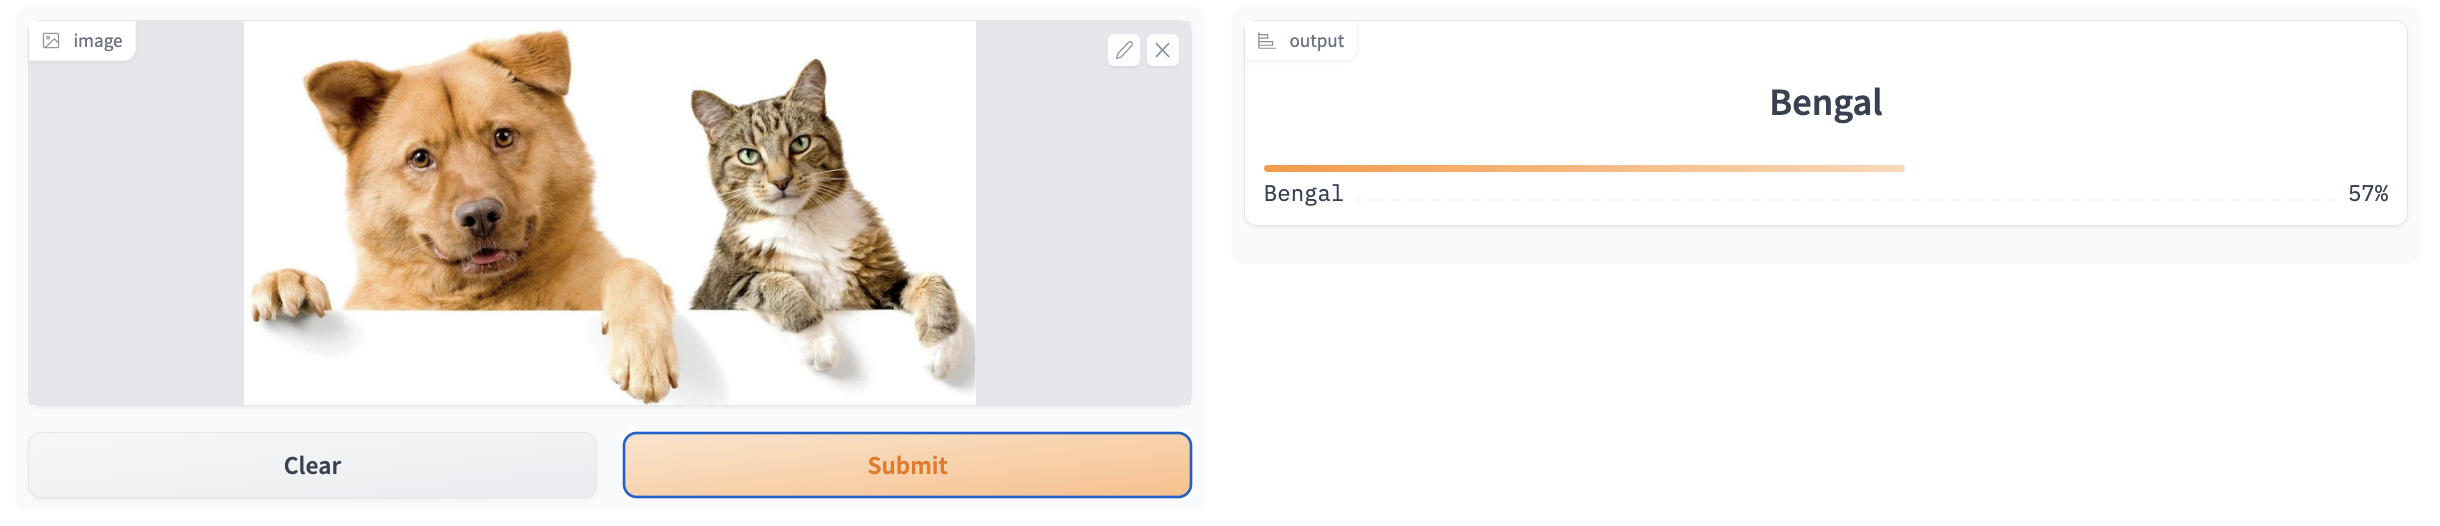

The second problem is the classifier will always pick a class from the 37 pet breeds even if an image is not a pet. 

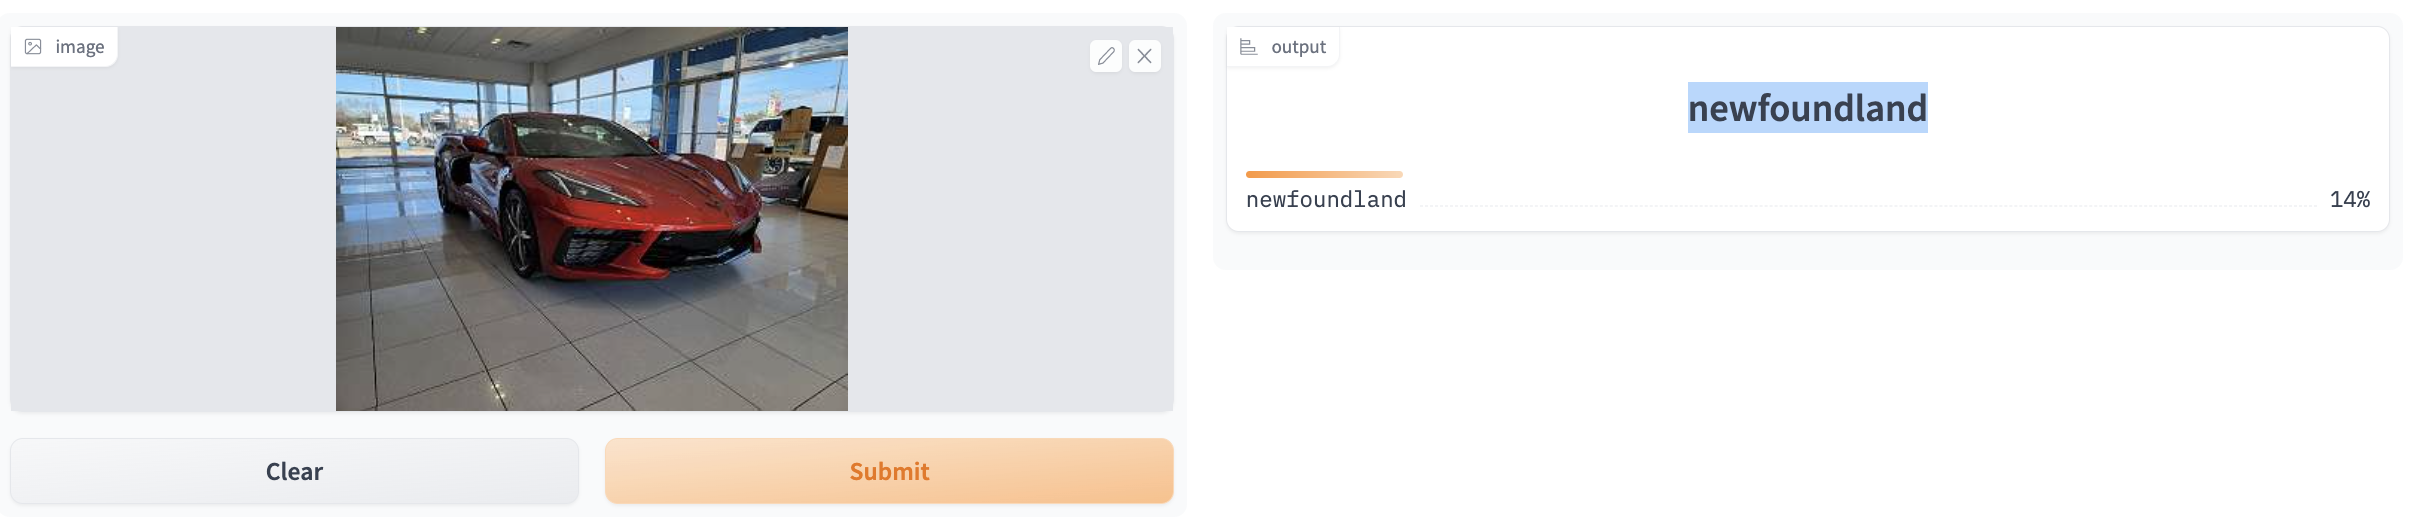

To solve these problems, we need a multi-label classifier. Differ from a multi-class classifier a multi-label classifier can outputs more than one class per input exmaple. To train a multi-label classfier, we need to load a different dataset as the pet breed dataset only has one label per image. 

In [ ]:
from fastai.vision.all import *
data_path = untar_data(URLs.PASCAL_2007)
data_path

/Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so, 6): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: /Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so
  Expected in: /Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torch/lib/libtorch_cpu.dylib
 in /Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torchvision/image.so
  warn(f"Failed to load image Python extensio

Path('/Users/jerryyu/.fastai/data/pascal_2007')

According to the [PASCAL website](http://host.robots.ox.ac.uk/pascal/VOC/), the 2007 dataset contains 20 classes and 9963 images splitted into train/validation/test set. These 20 classes are:

- Person: person
- Animal: bird, cat, cow, dog, horse, sheep
- Vehicle: aeroplane, bicycle, boat, bus, car, motorbike, train
- Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor

The dataset is structured like so

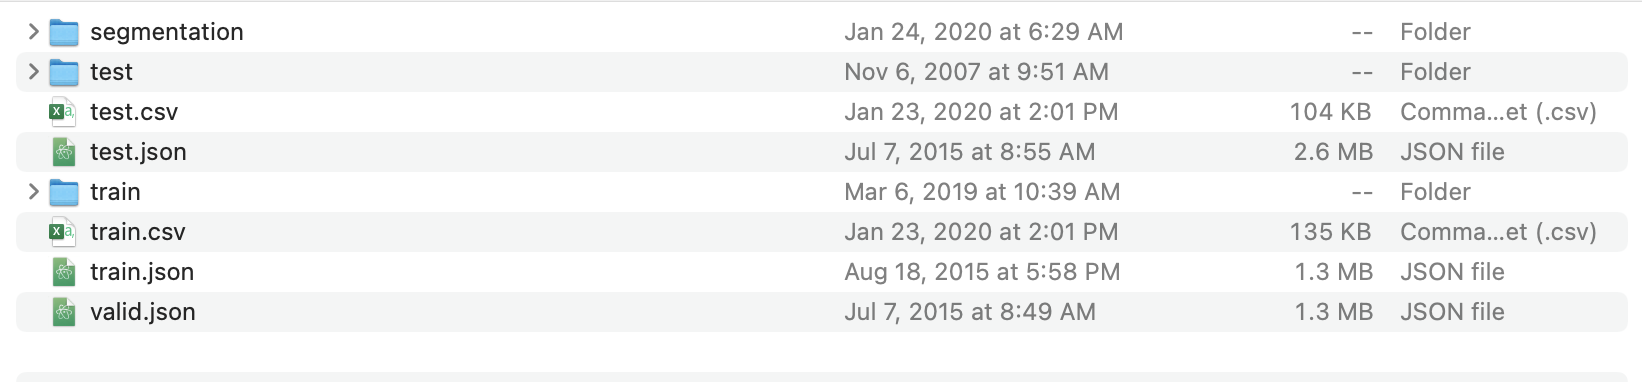

Training and validation images are stored in the train folder and test images are stored in the test folder. The train.csv and test.csv files contain labels for each image. Please take a look at how an image is labeled. 

In [ ]:
import pandas as pd
df = pd.read_csv(data_path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


The labels are stored in a labels column. If an imange has more than one label, each label is separated by a space. The is_valid column tells whether an image belongs to the training set or validation set. Because this dataset was created for a challange. The creator wants to make sure every competitor uses the same split for the compitition. Let's use the DataBlock API to build our dataloaders step by step. 

In [ ]:
db = DataBlock()
data = db.datasets(df)
x, y = data.train[0]
x,y

(fname       006852.jpg
 labels      sofa chair
 is_valid         False
 Name: 3456, dtype: object,
 fname       006852.jpg
 labels      sofa chair
 is_valid         False
 Name: 3456, dtype: object)

fastai creates a training and validation set from the train.csv file. Right now x, y are the same because we didn't tell fastai how to create our inputs and targets from this file. By default, fastai just set the input and target of each example to be the the value of the entire row. We need to write a function to extract the labels from the labels column and split them by a space. We also need a function to get the path of each image. 

In [ ]:
def get_labels(row):
    return row['labels'].split()

def get_fname(row):
    return data_path/'train'/row['fname']

In [ ]:
assert get_labels(df.iloc[2]) == ['horse', 'person']
assert get_fname(df.iloc[0]) ==  (data_path/'train'/'000005.jpg')

Let's rebuild our dataset and see how x and y look like now

In [ ]:
data = DataBlock(get_x=get_fname, get_y=get_labels).datasets(df)
x, y = data.train[0]
x,y

(Path('/Users/jerryyu/.fastai/data/pascal_2007/train/003537.jpg'), ['train'])

Now we have the labels and the file path but these are not the things we feed into our model. For a multi-label image classifier, we need the inputs to be image tensors and targets to be one-hot encoded tensors. We can use the blocks parameter to tell fastai to do the conversion for us. 

In [ ]:
data = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=get_fname, 
    get_y=get_labels
).datasets(df)
x, y = data.train[0]
x,y

(PILImage mode=RGB size=500x342,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
                      0., 0., 1., 0., 0.]))

Note that x and y are not tensors. In fastai, there are three types of transform: type transform, item transform, and batch transform. 

Type transform is the base level transform. It takes the source data and transform data into the format suitable for traning our model. In our example, type transfrom takes our csv file and transfrom the data to PILImage (for the input) and one-hot encoded category (for the target). 

Item transform is performed after type transform. It transfroms whatever we get from type transfrom to tensors. You can also define other item transformations by passing these transformation to the item_tfms parameter in the DataLock method.

Batch transform is performed after item transform. It applies transformations to the whole batch. Batch transform includes Cuda, IntToFloatTensor and any custom transfrom you pass to the batch_tfms parameter. 

In our example, we will use item transform to make all the images the same size and batch transform to do augmentation. 

In [ ]:
data = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=get_fname, 
    get_y=get_labels,
    item_tfms = Resize(460),
    batch_tfms = aug_transforms(size=224, min_scale=0.75)
).datasets(df)
x, y = data.train[0]
x,y

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

Our dataset looks good now. Let's create our dataloaders.

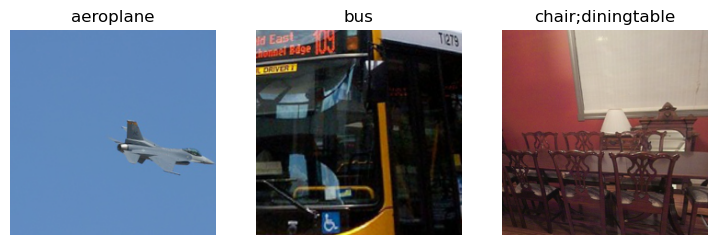

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_x=get_fname, 
    get_y=get_labels,
    item_tfms = Resize(460),
    batch_tfms = aug_transforms(size=224, min_scale=0.75)
).dataloaders(df)

dls.show_batch(max_n=3)

Now our dataloaders is ready. To create our learner, we need 4 things: dataloaders, model, metrics, and loss function. We already have our dataloaders. fastai can provide the model and loss function. All is left is to define our metrics. We can't use the error_rate metrics because we are dealing with a multi-label classifier. We need to define our own way of calculating accuracy (error rate). 

In [ ]:
import torch
def multi_label_accuracy(output, target, threshold=0.5, sigmoid=True):
    '''
    If sigmoid is true, output is logits with size bs * n_classes.
    If sigmoid is false, output is probability with size bs * n_classes.
    Target is a one-hot encoded tensor with size bs * n_classes. 
    '''
    if sigmoid == True: 
        pred = torch.sigmoid(output)
    else:
        pred = output
    return ((pred > threshold) == target).float().mean()

In [ ]:
assert multi_label_accuracy(torch.tensor([-4, 0.3, 0.2, -1]), torch.tensor([0,1,0,1])) == 0.5

Now everything is ready, we can create our learner to train our model

In [ ]:
learner = vision_learner(dls, resnet50, metrics=partial(multi_label_accuracy, threshold=0.5))
learner.fine_tune(2)

/Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/jerryyu/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,multi_label_accuracy,time
0,0.786185,0.456157,0.810230,22:43


epoch,train_loss,valid_loss,multi_label_accuracy,time
0,0.423361,0.210357,0.959780,25:11
1,0.271580,0.145638,0.970858,28:34


With threshold = 0.5, our accuracy is 97%. The threshold is a hyperparameter we need to choose for our model. Let's see how varying the threshold can change our model's accuracy. First we get the predictions of our validaiton set by using the get_preds method. The preditions returned by get_preds is probability so we need to set sigmoid = False when passing the predictions to our accurancy funciton.

In [ ]:
preds, targets = learner.get_preds()

In [ ]:
multi_label_accuracy(preds, targets, threshold = 0.8, sigmoid=False)

TensorBase(0.9725)

In [ ]:
multi_label_accuracy(preds, targets, threshold = 0.3, sigmoid=False)

TensorBase(0.9554)

To pick the threshold that yields the best accuracy, we can plot a curve of accuracy at every threshold . 

[<matplotlib.lines.Line2D>]

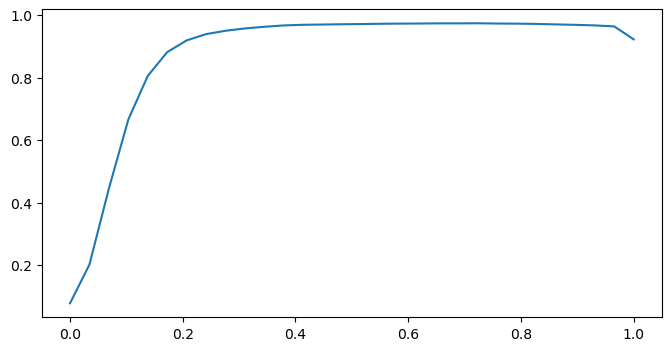

In [ ]:
x = torch.linspace(0,1,30)
accuracy = [multi_label_accuracy(preds, targets, threshold = i, sigmoid=False) for i in x]

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(x, accuracy)

From this curve, thresholds above 0.4 barely change the accuracy, so any value betwwen 0.4 and 0.9 would work. 

In [ ]:
learner.export('model.pkl')